# Local Dimension

In this tutorial we use tools from Topological Data Analysis (TDA) to study the local geometry of point clouds. 

In [1]:
from gtda.plotting import plot_point_cloud
from simplicial import *

import numpy as np

# Dimensionality

What is 'local structure', how can we formalize it? 

We propose an answer to this question based on the notion of 'dimensionality'. Intuitively, the dimension around a point is the degrees of freedom around that point. Data sets are often given in high dimensional space, but most of the time their intrinsic dimension is much smaller. One way to estimate the 'local dimension' around each point in a data set is to use the topological properties of the data points' neighbourhoods.

We illustrate the tool we developped by considering three shapes: the line, the plane and the cube as plotted below. The main different between these, are ... their dimensions!

In [76]:
# First generate three point clouds, differing by their dimension.

line = np.array([[0, 0, z] for z in np.arange(0, 1, 1/10)])
plane = np.array([[0, y, z] for z in np.arange(0, 1, 1/10) for y in np.arange(0, 1, 1/10)])
cube = np.array([[x, y, z] for x in np.arange(0, 1, 1/10) for y in np.arange(0, 1, 1/10) for z in np.arange(0, 1, 1/10)])

line_plane_cube = np.append(np.append(line, [p+[0.5, -0.5, 0] for p in plane], axis=0), [p+[1, -0.5 ,0] for p in cube], axis=0)

plot_point_cloud(line_plane_cube)

In [78]:
# A common object in TDA is a persistent diagrams. In order to interpret these,
# we introduce some helper functions:
from gtda.diagrams.features import PersistenceEntropy

def modified_persistence_entropy(diags):
    """ This is a custom vectorizer, similar to functions
    in gtda.diagrams.features. Inputs a sequence of persistence
    diagrams, and outputs a sequence of vectors"""
    return 2**PersistenceEntropy().fit_transform(diags)

def plot_coloured_cloud(local_hom, diags, point_cloud, dimension):
    """ This is a custom plotting function, that plots the point cloud and colours 
     the points according to their persistence diagrams in the given dimension"""
    dim_index = np.argwhere(np.array(local_hom.homology_dimensions)==dimension)[0][0]
    dim_vects = modified_persistence_entropy(diags) #Modified this to not store diags
    return plot_point_cloud(point_cloud,
                            plotly_params={"trace" : {"marker": {"color":dim_vects[:, dim_index],
                                                                 "size":6,
                                                                 "showscale":True}, 
                                                     "text":['color: '+str(i) for i in dim_vects[:, dim_index]]}
                                          })


To compute and represent the dimensionality at each point we do the following:
- To each point in the data set we find a vector $(d_1, \dots, d_i)$ where $d_1$ correponds to 1-dimensional features, $\dots$, $d_i$ to  $i$-dimensional features. The $i$-th dimensional feature correspond to the $i$-th Betti number of the coned off local neighborhood around that point. More on this in the 'How does it work' section below!
- We then plot the point cloud by colouring the points with one of the computed features.


In [80]:
# initialize a local homology transformer. 
# the notion of neighborhood here is determined by the number of closest neighbors to consider
lh_line = KNeighborsLocalVietorisRips(n_neighbors=(1, 7), n_jobs = -1)

# fit_tranform the transformer to get the persistence diagrams
diags = lh_line.fit_transform(line)

# plot the results of local homology dimension 1:
plot_coloured_cloud(lh_line, diags, line, 1)

For each point not on the boundary in the example above, the algorithm only detects one local feature, in dimension 1!

In [83]:
#plane coloured with two dimensional features
# the notion of neighborhood here is determined by radii.
lh_plane = RadiusLocalVietorisRips(radii=(0.001,0.3), 
                     homology_dimensions=(1, 2, 3), n_jobs = -1)

# Fit_tranform the transformer
diags = lh_plane.fit_transform(plane)

# Plot the results of local homology dimension 2:
plot_coloured_cloud(lh_plane, diags, plane, 2)

In the two examples above we plotted the one dimensional features of the line, and the two dimensional features of the plane. Both are equal to 1, except at the borders. 


In the following example, we  consider a point cloud with varying dimensionality. We plot the three shapes next to each other. We encourage you to play around with the dimension parameter in the plotting function below, to compare the local structure of points in the line, plane and cube! One sees that one dimensional features are observed in all three shapes, but two dimensional features only exist in the plane and three dimensional features only exist in the cube.

In [84]:
lh_line_plane_cube = RadiusLocalVietorisRips(radii=(0.01, 0.25), 
                     homology_dimensions=(1, 2, 3))



# Fit_tranform the transformer
diags = lh_line_plane_cube.fit_transform(line_plane_cube)


In [92]:
# Plot the results of local homology dimension 1. We encourage you to change the dimension parameter.
plot_coloured_cloud(lh_line_plane_cube, diags, line_plane_cube, dimension=1)

In [95]:
# First generate the point cloud
line1=[[x, 0, 0] for x in np.arange(-1,1, 1/10)]
line2=[[0, y, 0] for y in np.arange(-1,1, 1/10)]
line3=[[x, 1, 0] for x in np.arange(-1,1, 1/10)]
lines=np.array(line1+line2+line3)

# Plot the point cloud
plot_point_cloud(lines)

Our last example is inherently one dimensional, but the point cloud admits some interesting local structures, there are 4 different types of points:
- The 'edge points', with no local structure
- The 'line points' which locally look like one dimensinoal lines.
- The 'intersection points', which locally looks like an X.
- The 'intersection points', which locally looks like a T.

The next block looks at the local homology features!

In [96]:
# Initialize the radius local homology transformer
lh_lines = RadiusLocalVietorisRips(radii=(0.21, 0.31), 
                     homology_dimensions=(0, 1), n_jobs = -1)

# fit_tranform
diags = lh_lines.fit_transform(lines)

# Plot the results of local homology dimension 1:
plot_coloured_cloud(lh_lines, diags, np.array(lines), dimension=1)

Notice that the one-dimensional feature counts the branches at a given point!

We encourage you to change the values of the radii parameter. If you are curious of what these parameters are, please scroll down to the 'How idoes it work' section.

# How does it work?

As the mathematics behind this algorithm is quite involved, we give an explanation for the one-dimensional example. We also give a picture for the process for a 2 dimensional example.

A central theme in Topology is the study of properties that are invariant under deformation. A popular one-dimensional invariant is the number of 'loops' in the space. For a graph, the number of 'loops' is the number of cycles of that graph. In the case of connected graphs this is equal to $1-\chi(G)$, where $\chi(G)=|V|-|E|$ is the Euler characteristic of the graph, and $|V|$ and $|E|$ are the number of vertices and edges respectively. 

However, although all trees have Euler characteristic 1, they can admit very different local behaviour. The Euler characteristic alone will not be enough, we therefore have to do a trick:

The first step is to discard points that are far away, since they do not affect the local geometry around a point. We thus keep points that are closer than the second radius (either a distance from the point for the RadiusLocalVietrosiRips transformer, or the closest neighbors for the KNeighborsVietorisRips transformer).

The second step is the one making loops reflect dimensionality. From a line, how can we obtain a loop? We stick the two ends of the line together! This trick can be thought of as 'coning' off the endpoints: adding an extra point and linking some points (the furthest points) to this extra point. Our algorithm cones off the points that lie in between the first and second radii, as depicted below.

So what are the Euler characteristic of the resulting graph below?
It one has two vertices (at the intersection points) and 4 edges, so Euler characteristic 2! This relects the complexity at the point that we are considering!

We also added a 2-dimensional example: the disk. By coning off the furthest point, we end up with a sphere! Which only has nontrivial 2 dimensional features.

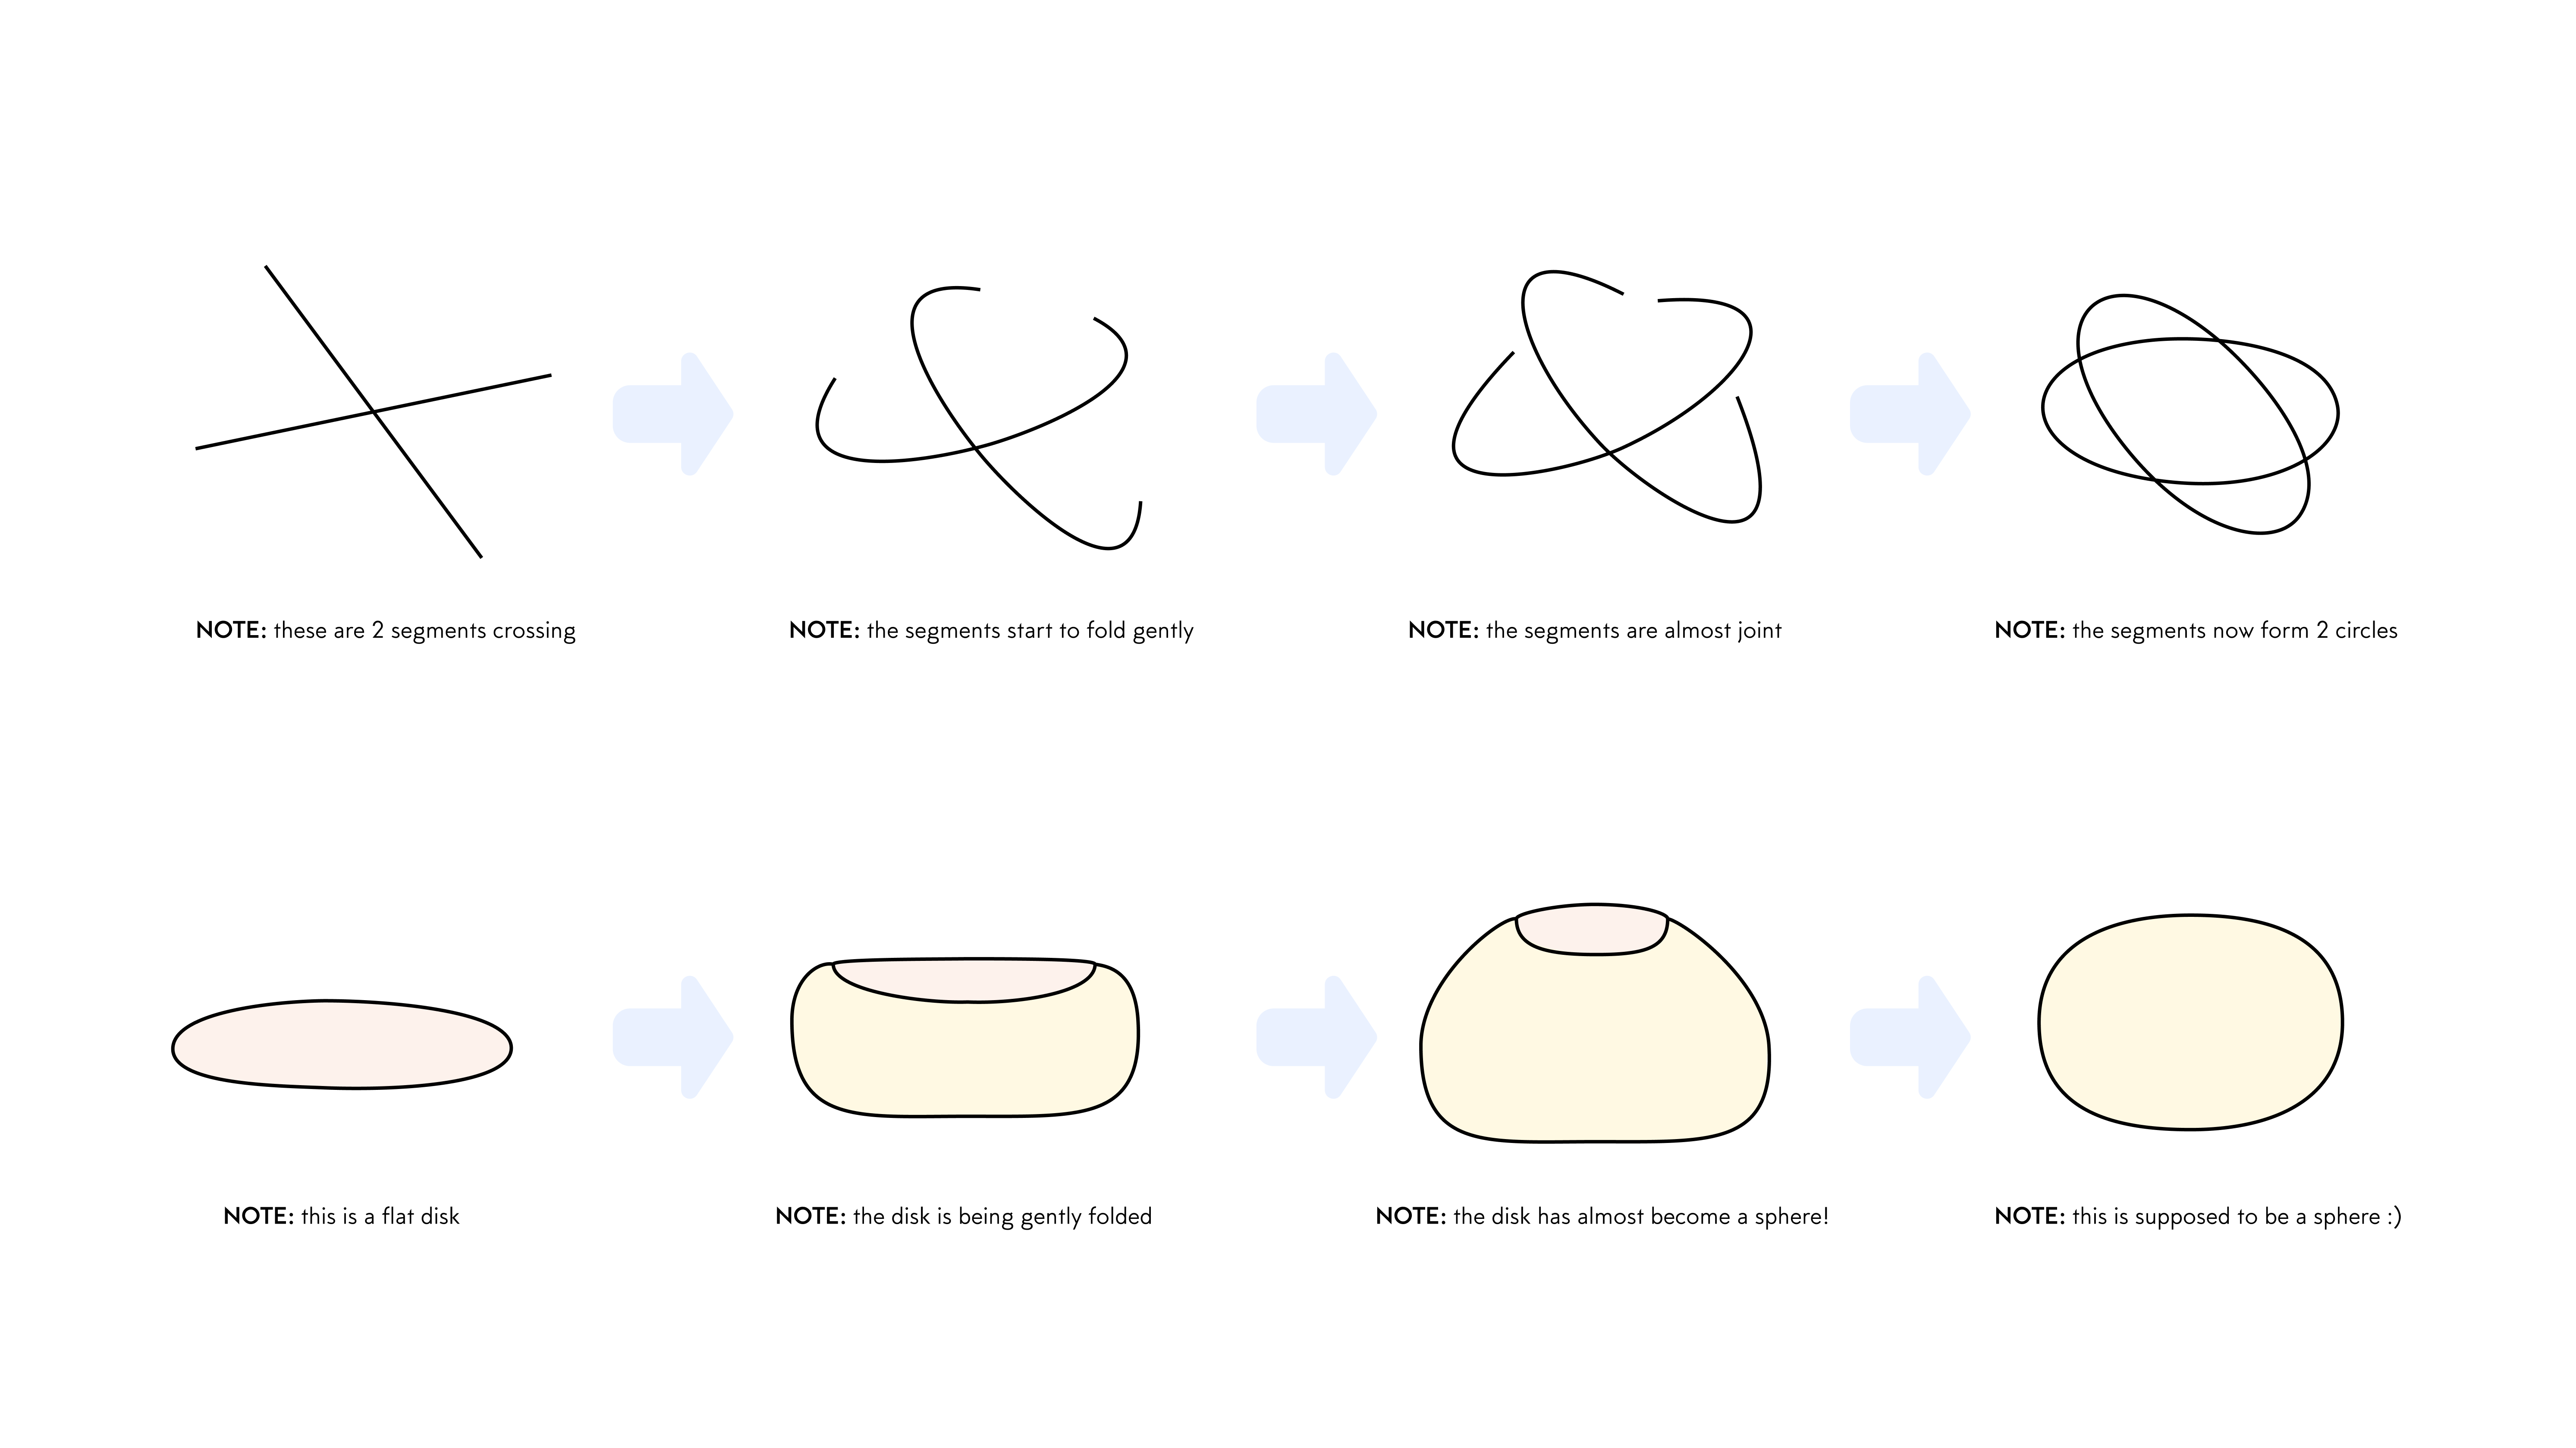